In [1]:
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors


import sys
sys.path.append('../../..')
from batchflow.opensets import Imagenette160
from batchflow import Pipeline, B, V, C, W

from batchflow.models.torch import ResNet34, ResBlock
from batchflow.models.torch.layers import ConvBlock

from batchflow.models.metrics import ClassificationMetrics
from batchflow.research import Research, Option, Results, KV, RP, REU, RI
from batchflow.utils import plot_results_by_config, show_research, print_results

In [2]:
# Global constants
NUM_ITERS = 35000                               # number of iterations to train each model for
N_REPS = 5                                      # number of times to repeat each model train
RESEARCH_NAME = 'research'                      # name of Research object
DEVICES = [3, 4, 5, 6, 7]                       # devices to use
WORKERS = len(DEVICES)                          # number of simultaneously trained models
TEST_FREQUENCY = 150
BATCH_SIZE = 64

dataset = Imagenette160()                       # dataset to train models on
DS_TRAIN_LEN = len(dataset.train)

In [3]:
domain = (Option('decay', [
                         KV({'name': 'exp', 'gamma': 0.97, 'step': DS_TRAIN_LEN // BATCH_SIZE}, 
                              'ordinary'),
                          KV([{'name': 'exp', 'gamma': 1.01, 'step': 2, 'last_iter': 500}, {'name': 'exp', 'gamma': 0.9993, 'step': 2, 'first_iter': 501}],
                             'with_warmup'),
                          KV({'name': 'CyclicLR', 'base_lr': 0.0003, 'max_lr': 0.003, 'step_size_up': 100, 'cycle_momentum': False, 'step': 1},
                             'cyclic'),
                          KV(None,
                             'None')
                         ]))

In [4]:
config = {
    'inputs/labels/classes': 10,
    'head/layout': 'Vf',
    'head/units': 10,
    'optimizer': {'name': 'Adam', 'lr': 0.001},
    'decay': C('decay'),
    'device': C('device'),
}

In [5]:
train_root = (dataset.train.p      
                  .crop(shape=(160, 160), origin='center')
                  .to_array(channels='first', dtype=np.float32)
                  .multiply(multiplier=1/255)
                  .run_later(BATCH_SIZE, n_epochs=None, drop_last=True,
                             shuffle=True, prefetch=5)
                   )

train_pipeline = (Pipeline()
                  .init_variable('loss')
                  .init_variable('lr')
                  .init_model('dynamic', ResNet34, 'my_model', config=config) 
                  .train_model('my_model', B('images'), B('labels'), 
                               fetches=['loss', 'lr'], 
                               save_to=[V('loss'), V('lr')],
                               use_lock=True)
                 )

In [6]:
def acc(iteration, import_from):
    pipeline = (dataset.test.p
                 .import_model('my_model', import_from)
                 .init_variable('true', [])
                 .update(V('true', mode='a'), B.labels) 
                 .init_variable('predictions', [])
                 .crop(shape=(160, 160), origin='center')
                 .to_array(channels='first', dtype=np.float32)
                 .multiply(multiplier=1/255)
                 .predict_model('my_model', B('images'), fetches='predictions',
                                save_to=V('predictions', mode='a'))
                 )
    pipeline.run(128, n_epochs=1, drop_last=False, shuffle=True)
    pred = np.concatenate(pipeline.v('predictions'))
    true = np.concatenate(pipeline.v('true'))
    accuracy = ClassificationMetrics(true, pred, fmt='logits',
                                     num_classes=10, axis=1).accuracy()
    return accuracy

In [7]:
research = (Research()
            .init_domain(domain, n_reps=N_REPS)
            .add_pipeline(root=train_root, branch=train_pipeline, variables=['loss', 'lr'],
                          name='train_ppl', logging=True)
            .add_callable(acc, returns='acc_vall', name='acc_fn', execute=TEST_FREQUENCY,
                          iteration=RI(), import_from=RP('train_ppl')))

In [8]:
!rm -rf research

research.run(NUM_ITERS, name=RESEARCH_NAME,
             devices=DEVICES, workers=WORKERS,
             bar=True)

Research research is starting...


Domain updated: 0: 100%|██████████| 700000/700000.0 [17:36:16<00:00, 11.05it/s]  


In [9]:
%%time
results = Results(path=RESEARCH_NAME, concat_config=True)

CPU times: user 8min 2s, sys: 0 ns, total: 8min 2s
Wall time: 8min 2s


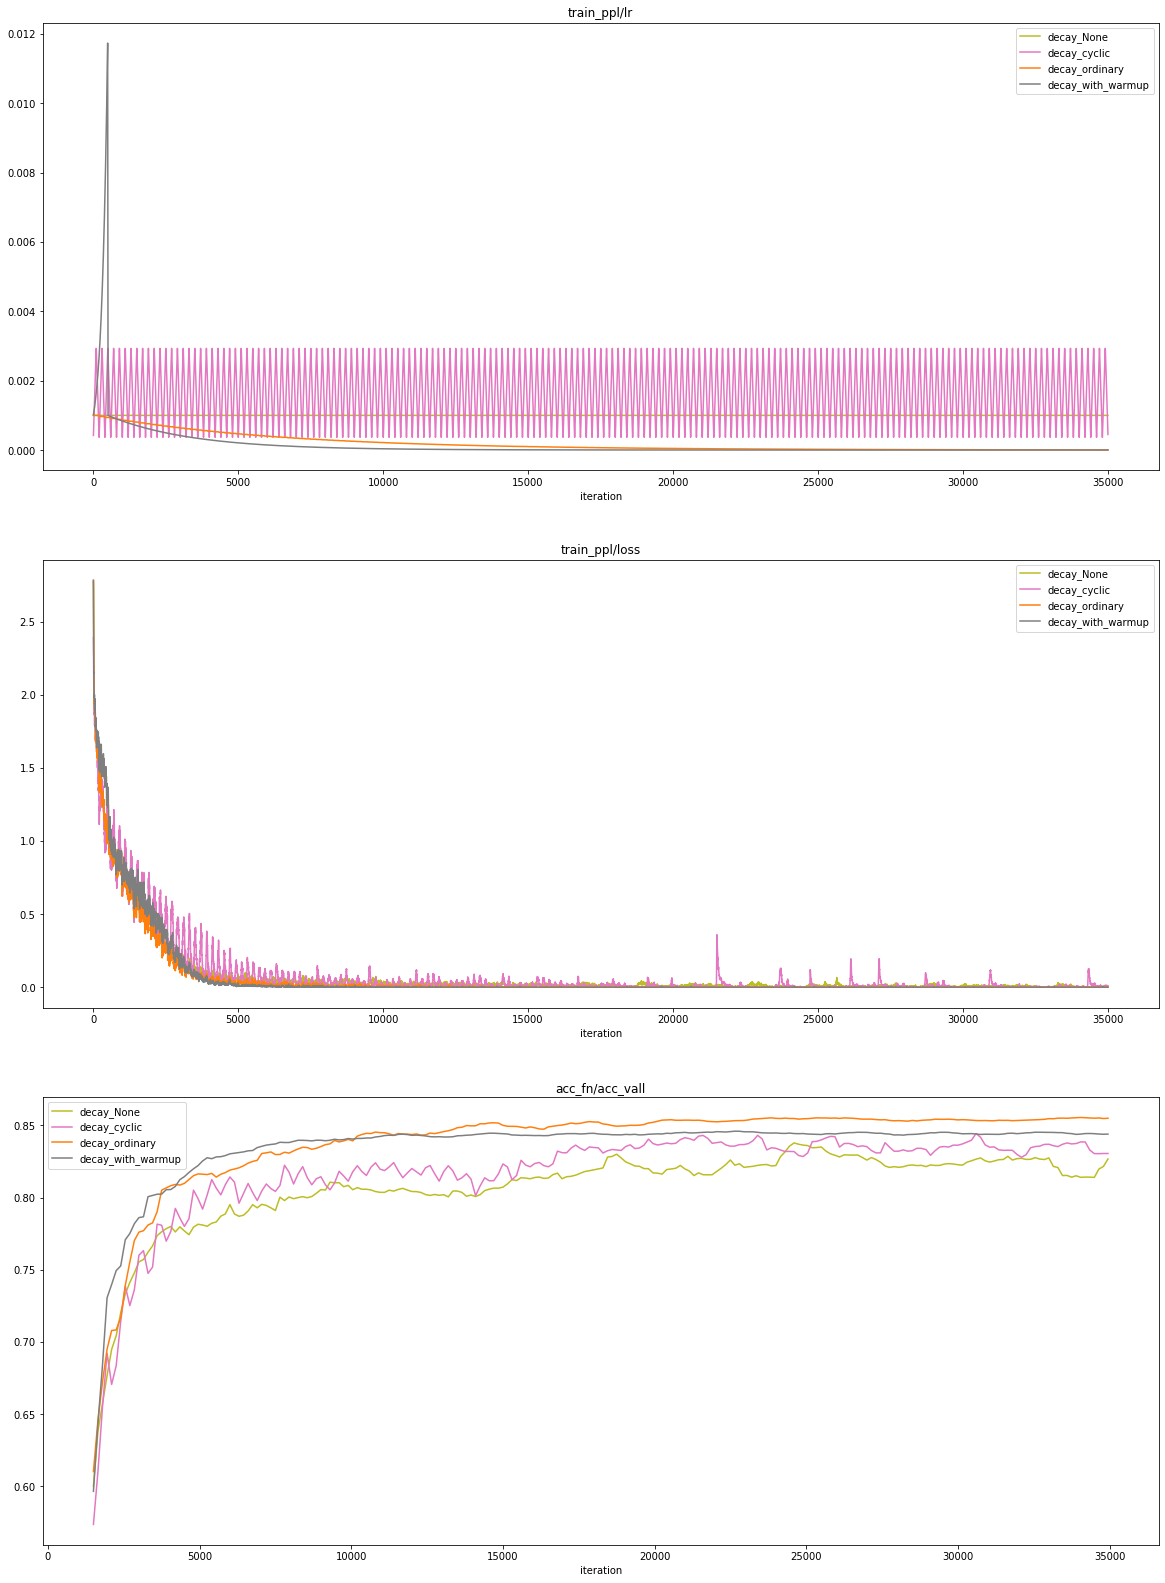

In [29]:
show_research(results.df, layout=['train_ppl/lr', 'train_ppl/loss', 'acc_fn/acc_vall'], average_repetitions=True, 
              color=list(mcolors.TABLEAU_COLORS.keys()), log_scale=False, rolling_window=10, 
              nrows=3, ncols=1, figsize=(20, 28))

In [11]:
print_results(results.df, 'acc_fn/acc_vall', False, ascending=True, n_last=100)

,acc_fn_0,acc_fn_2,acc_fn_3,acc_fn_1,acc_fn_4,acc_fn_mean,acc_fn_std
decay_None,0.843943,0.798768,0.850103,0.817248,0.804928,0.822998,0.020591
decay_cyclic,0.825462,0.852156,0.794661,0.843943,0.854209,0.834086,0.022169
decay_ordinary,0.878850,0.858316,0.831622,0.852156,0.858316,0.855852,0.015112
decay_with_warmup,0.854209,0.858316,0.819302,0.848049,0.839836,0.843943,0.013805
